In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from matplotlib import mlab
import math


## View Data and Picks (2014)

In [2]:
field_waveforms = np.load('data/field/meq_waveforms/2014_Processed_Selected/waveforms_2014.npy')
wf_eventIDs = np.load('data/field/meq_waveforms/2014_Processed_Selected/waveforms_eventIDs.npy')
mypicks_arr = np.load('data/field/meq_waveforms/2014_Processed_Selected/Best_Field_Picks.npy')
all_stationIDs_borehole = ['NN07', 'NN09', 'NN17', 'NN18', 'NN19', 'NN21', 'NN24', 'NN32']

print(field_waveforms.shape)
print(wf_eventIDs.shape)
print(mypicks_arr.shape)

(292, 8, 4000)
(292,)
(292, 8)


### Spectrogram functions

In [3]:
def _nearest_pow_2(x):
    a = math.pow(2, math.ceil(np.log2(x)))
    b = math.pow(2, math.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

def custom_spec(trace):
    samp_rate = 250
    wlen = 128 / samp_rate
    mult=8.0
    nfft = int(_nearest_pow_2(wlen * samp_rate))
    mult = int(_nearest_pow_2(mult))
    mult = mult * nfft
    per_lap=0.9
    nlap = int(nfft * float(per_lap))

    # specgram, freq, time = mlab.specgram(Trace.data,Fs = 250)
    data = trace - np.mean(trace)
    specgram, freq, time = mlab.specgram(data, Fs=samp_rate, NFFT=nfft,
                                            pad_to=mult, noverlap=nlap)

    # specgram = np.sqrt(specgram[1:, :])
    specgram = np.sqrt(specgram)
    # freq = freq[1:]
    # print(freq)
    # halfbin_time = (time[1] - time[0]) / 2.0
    # halfbin_freq = (freq[1] - freq[0]) / 2.0
    # extent = (time[0] - halfbin_time, time[-1] + halfbin_time,
    #                 freq[0] - halfbin_freq, freq[-1] + halfbin_freq)
    extent = (time[0], time[-1], freq[0], freq[-1])
    specgram = np.flipud(specgram)
    return specgram,extent

## Fig-11 Spectogram

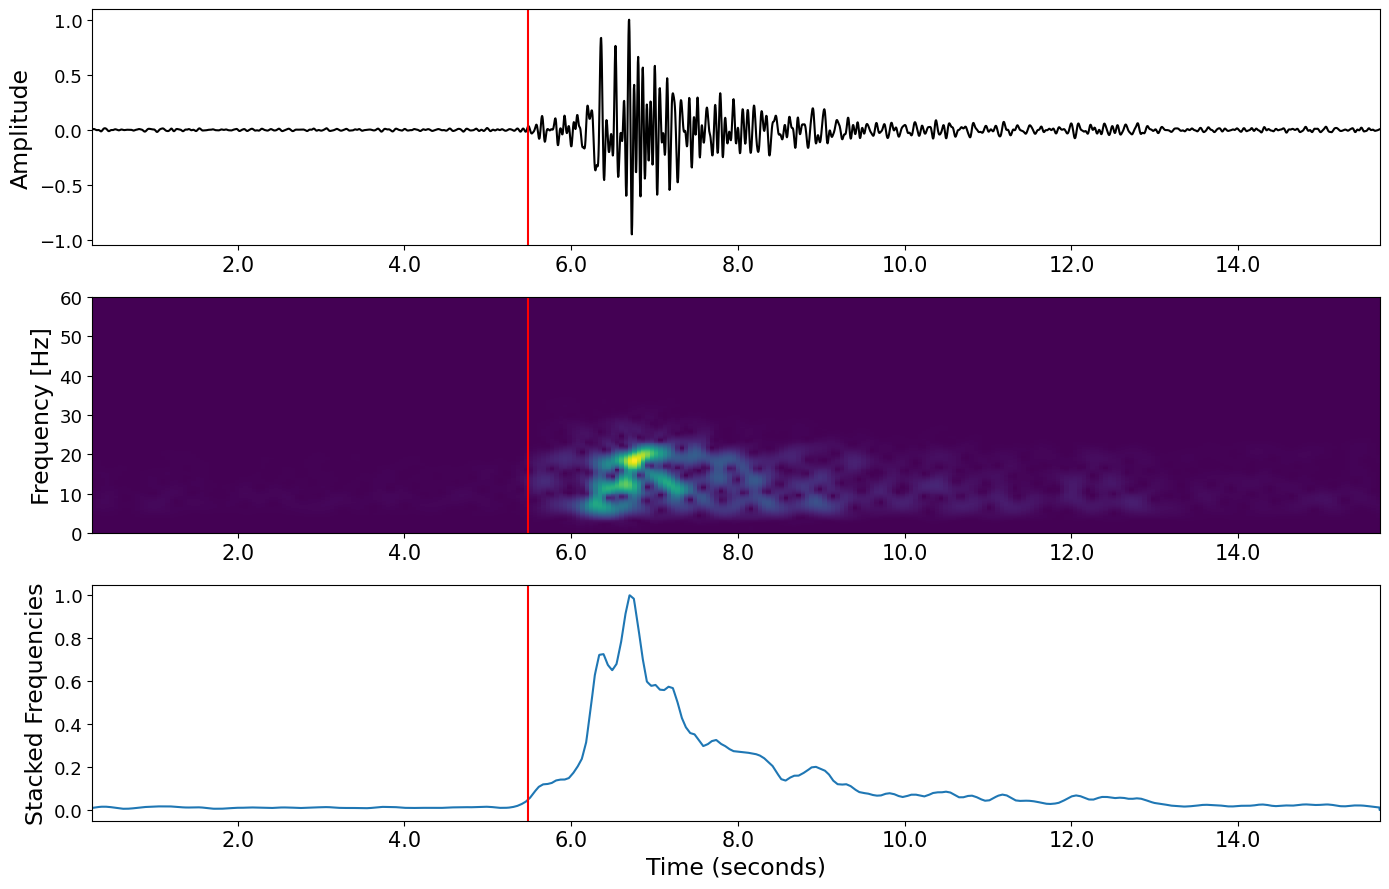

In [4]:
# check one spectrogram

event_i = 72 
j = 7 #trace

sample = field_waveforms[event_i,j]
trig = mypicks_arr[event_i,j] #original

### calculate spectrogram
dt = 0.004
specgram,extent = custom_spec(sample)
mod_extent = [extent[0]/dt,extent[1]/dt,extent[2],extent[3]]
mod_extent_t = [extent[0],extent[1],extent[2],extent[3]]
### interpolate spectrogram on time axis
xcurrent = np.arange(specgram.shape[1])
## find diff
num_diff = int(mod_extent[1]-mod_extent[0])
xnew = np.linspace(xcurrent[0],xcurrent[-1],num=num_diff,endpoint=True)
interp_specgram = []
for i in range(specgram.shape[0]):
    interp = np.interp(xnew,xcurrent,specgram[i])
    interp_specgram.append(interp)
interp_specgram = np.array(interp_specgram)
## stacked specgram starts at mod_extent[0] to mod_extent[1]
stacked_specgram = np.mean(interp_specgram,axis=0)
stacked_specgram = stacked_specgram/np.max(abs(stacked_specgram))
##put into arr
ss_arr = np.zeros(4000)
ss_arr[int(mod_extent[0]):int(mod_extent[0])+len(stacked_specgram)]= stacked_specgram

#plot trace
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13

xticks = np.arange(0,4000,500)

fig,axs = plt.subplots(3,1,figsize=(14,9))
ax = axs[0]
ax.plot(sample,color='black')
ax.axvline(trig,color='red')
# ax.axvline(trig2,color='darkgreen')
ax.set_xticks(xticks)
ax.set_xticklabels(xticks*dt,fontsize=15)
ax.set_xlim(mod_extent[0], mod_extent[1]) #set here to align with spectrogram
ax.set_ylabel('Amplitude',fontsize=17)

#plot spectrogram
ax = axs[1]
ax.imshow(specgram,cmap='viridis',interpolation="nearest",extent=mod_extent)
ax.axvline(trig,color='red')
ax.set_ylabel('Frequency [Hz]',fontsize=17)
ax.axis('tight')
# ax.axvline(trig2,color='darkgreen')
ax.set_xticks(xticks)
ax.set_xticklabels(xticks*dt,fontsize=15)
ax.set_xlim(mod_extent[0], mod_extent[1])
ax.set_ylim(0,60)

#plot stacked spectrogram
ax = axs[2]
# ax.plot(stacked_specgram)
ax.plot(ss_arr)
ax.axvline(trig,color='red')
# ax.axvline(trig2,color='darkgreen')
ax.set_xticks(xticks)
ax.set_xticklabels(xticks*dt,fontsize=15)
ax.set_xlim(mod_extent[0], mod_extent[1])
ax.set_xlabel('Time (seconds)',fontsize=17)
ax.set_ylabel('Stacked Frequencies',fontsize=17)

fig.tight_layout()
# plt.savefig('Figures/11-FieldData_FreqMap.jpg',dpi=300,bbox_inches='tight')


### View all traces

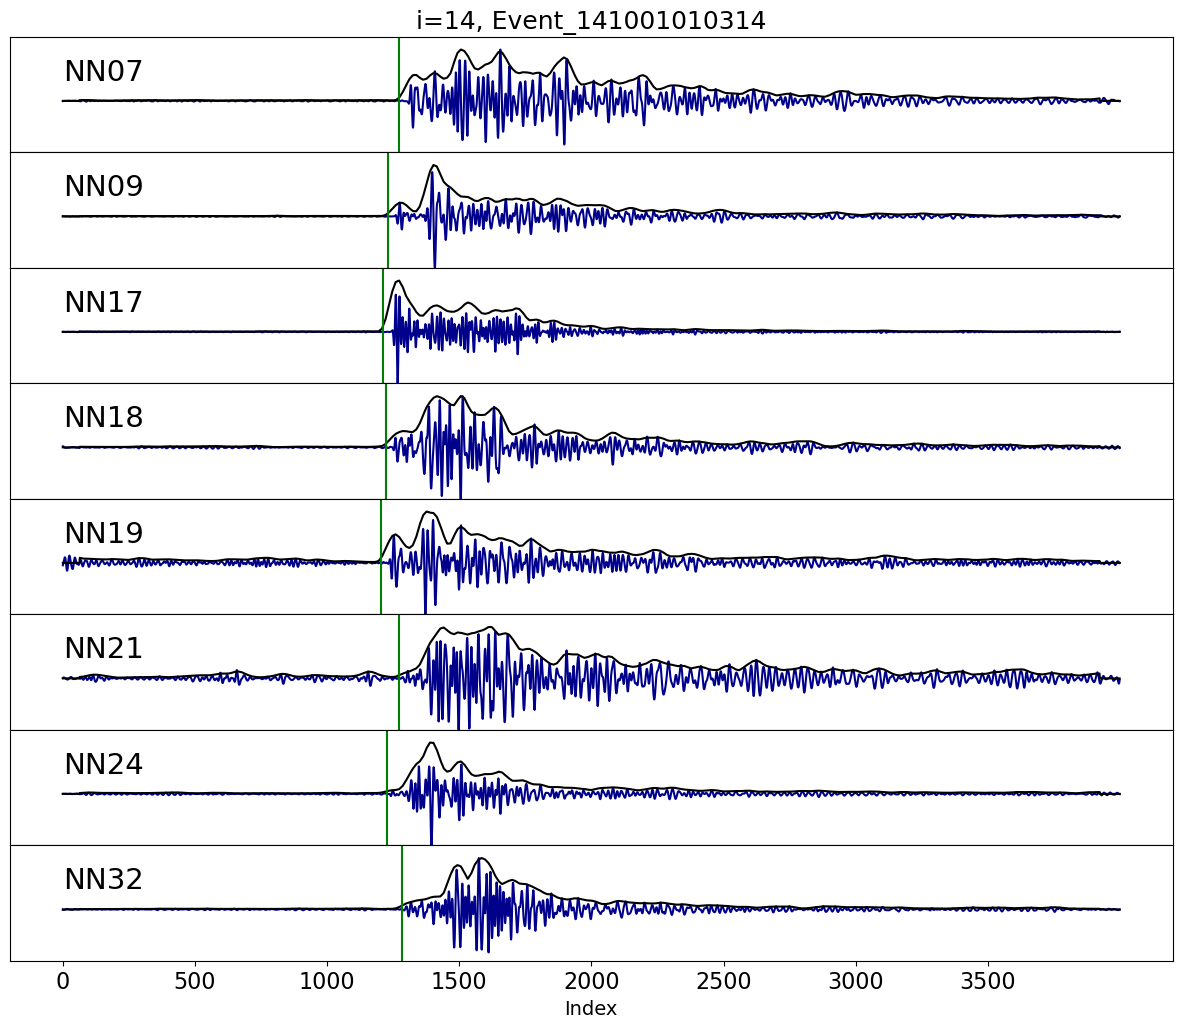

In [6]:
event_i = np.random.randint(292)
event_i = 14

###### calculate spectrogram ####

sample_field = field_waveforms[event_i]
dt = 0.004

stacked_specgram_arr = []
for i_tr in range(8):

    specgram,extent = custom_spec(sample_field[i_tr])
    mod_extent = [extent[0]/dt,extent[1]/dt,extent[2],extent[3]]
    ### interpolate spectrogram on time axis
    xcurrent = np.arange(specgram.shape[1])
    ## find diff
    num_diff = int(mod_extent[1]-mod_extent[0])
    xnew = np.linspace(xcurrent[0],xcurrent[-1],num=num_diff,endpoint=True)
    interp_specgram = []
    for i in range(specgram.shape[0]):
        interp = np.interp(xnew,xcurrent,specgram[i])
        interp_specgram.append(interp)
    interp_specgram = np.array(interp_specgram)
    ## stacked specgram starts at mod_extent[0] to mod_extent[1]
    stacked_specgram = np.mean(interp_specgram,axis=0)
    stacked_specgram = stacked_specgram/np.max(abs(stacked_specgram))
    ##put into arr
    ss_arr = np.zeros(4000)
    ss_arr[int(mod_extent[0]):int(mod_extent[0])+len(stacked_specgram)]= stacked_specgram
    #append
    stacked_specgram_arr.append(ss_arr)
stacked_specgram_arr = np.array(stacked_specgram_arr)



                       
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
eventID = wf_eventIDs[event_i]

fig,axs = plt.subplots(8,1,figsize=(15,12))
for i in range(8):
    ax = axs[i]
    #get all station ID
    stationID = all_stationIDs_borehole[i]
    #plot field data
    ax.plot(field_waveforms[event_i,i],color='darkblue')
    #plot ss
    ax.plot(stacked_specgram_arr[i],color='black')
    ax.text(0.02,0.4,'{}'.format(stationID),fontsize=21)
    ax.set_ylim(-1,1.25)
    #plot trigger - new picks
    ax.axvline(mypicks_arr[event_i,i],color='green')
    #plot trigger - older picks
    # ax.axvline(mypicks_arr[event_i,i],color='red')
    #title
    if i == 0:
        ax.set_title('i={}, Event_{}'.format(event_i,eventID),fontsize=18)
    #turn off all tick except the last
    if i != 7:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    ######add appropriate tick labels
    if i==7:
        xticks = np.arange(0,4000,500)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
        ax.set_xlabel('Index',fontsize=14)
    ax.set_yticks([])
plt.subplots_adjust(wspace=0,hspace=0)